<a href="https://colab.research.google.com/github/idrissdjio/Transformers/blob/main/SER_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# os.chdir('/content/drive/MyDrive/CSCI-DeepLearning/FinalProject/dataset/input/speech-emotion-recognition-en/')
os.chdir('/content/drive/MyDrive/DeepLearning-Final/FinalProject/dataset/processed_csv/updated_csv')
# os.chdir('/content/drive/MyDrive/CSCI-DeepLearning/FinalProject/dataset/processed_csv')
!ls

checkpoints		  ravdess_crema_combined_processed_data.csv
crema_processed_data.csv  ravdess_processed_data.csv


In [3]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import IPython
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder,StandardScaler
import re
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [32]:
# def create_model(input_dims, output_dims, model_optimizer, model_loss):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_dims),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
#         tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
#         tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
#         tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
#         tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(output_dims, activation='softmax')
#     ])
#     model.compile(optimizer=model_optimizer, loss=model_loss, metrics=['accuracy'])
#     return model

def create_model(input_dims, output_dims, model_optimizer, model_loss):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_dims),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
        tf.keras.layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
        tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
        tf.keras.layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=5, strides=2, padding='same'),
        tf.keras.layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=3, strides=2, padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_dims, activation='softmax')
    ])
    model.compile(optimizer=model_optimizer, loss=model_loss, metrics=['accuracy'])
    return model

In [33]:
# CONSTANTS
optimizer = tf.keras.optimizers.legacy.Adam()
model_loss='categorical_crossentropy'
EPOCH=50
BATCH_SIZE=128
model_type='CNN based'
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

def create_model_checkpoint(file_path):
    model_checkpoint = ModelCheckpoint(
        filepath=file_path,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1
    )
    return model_checkpoint

In [7]:
def load_dataset(file_path):
    data_frame = pd.read_csv(file_path)
    return data_frame

In [8]:
def preprocess_data(X, Y, test_size_first_split=0.2, test_size_second_split=0.1, random_state=42, add_dim=False):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size_first_split, random_state=random_state, shuffle=True)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size_second_split, random_state=random_state, shuffle=True)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)

    return X_train, X_test, X_val, y_train, y_test, y_val

In [9]:
def plot_training_history(history,dataset_name):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (for {dataset_name} dataset) {model_type} model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss (for {dataset_name} dataset) {model_type} model')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

#CREMA

In [34]:
# Usage
processed_crema_path = './crema_processed_data.csv'
crema_df = load_dataset(processed_crema_path)
print("Dataset shape:", crema_df.shape)

Dataset shape: (29768, 2377)


In [35]:
crema_df = crema_df.fillna(0)
print(crema_df.isna().any())
crema_df.shape
X = crema_df.drop(labels='Emotion',axis=1)
Y = crema_df['Emotion']

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


In [36]:
label_encoder = LabelEncoder()
Y = to_categorical(label_encoder.fit_transform(Y))
Y

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [37]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(X, Y, add_dim=True)

In [38]:
(X_train.shape[1], 1)

(2376, 1)

In [40]:
model_crema = create_model((X_train.shape[1], 1), 6, optimizer, model_loss)
model_crema.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 2376, 512)         3072      
                                                                 
 batch_normalization_18 (Ba  (None, 2376, 512)         2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 1188, 512)         0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_19 (Ba  (None, 1188, 512)         2048      
 tchNormalization)                                               
                                                      

In [41]:
model_path = './checkpoints/crema_cnn.h5'
BATCH_SIZE=24
history_crema=model_crema.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE,callbacks=[early_stopping_callback,lr_scheduler, create_model_checkpoint(model_path)])

Epoch 1/50
893/893 [==============================] - ETA: 0s - loss: 1.5993 - accuracy: 0.3719
Epoch 1: val_accuracy improved from -inf to 0.41394, saving model to ./checkpoints/crema_cnn.h5
893/893 [==============================] - 124s 136ms/step - loss: 1.5993 - accuracy: 0.3719 - val_loss: 1.4690 - val_accuracy: 0.4139 - lr: 0.0010
Epoch 2/50
893/893 [==============================] - ETA: 0s - loss: 1.4103 - accuracy: 0.4389
Epoch 2: val_accuracy improved from 0.41394 to 0.43325, saving model to ./checkpoints/crema_cnn.h5
893/893 [==============================] - 121s 135ms/step - loss: 1.4103 - accuracy: 0.4389 - val_loss: 1.4054 - val_accuracy: 0.4332 - lr: 0.0010
Epoch 3/50
893/893 [==============================] - ETA: 0s - loss: 1.3197 - accuracy: 0.4809
Epoch 3: val_accuracy did not improve from 0.43325
893/893 [==============================] - 120s 134ms/step - loss: 1.3197 - accuracy: 0.4809 - val_loss: 1.4661 - val_accuracy: 0.4123 - lr: 0.0010
Epoch 4/50
893/893 [==

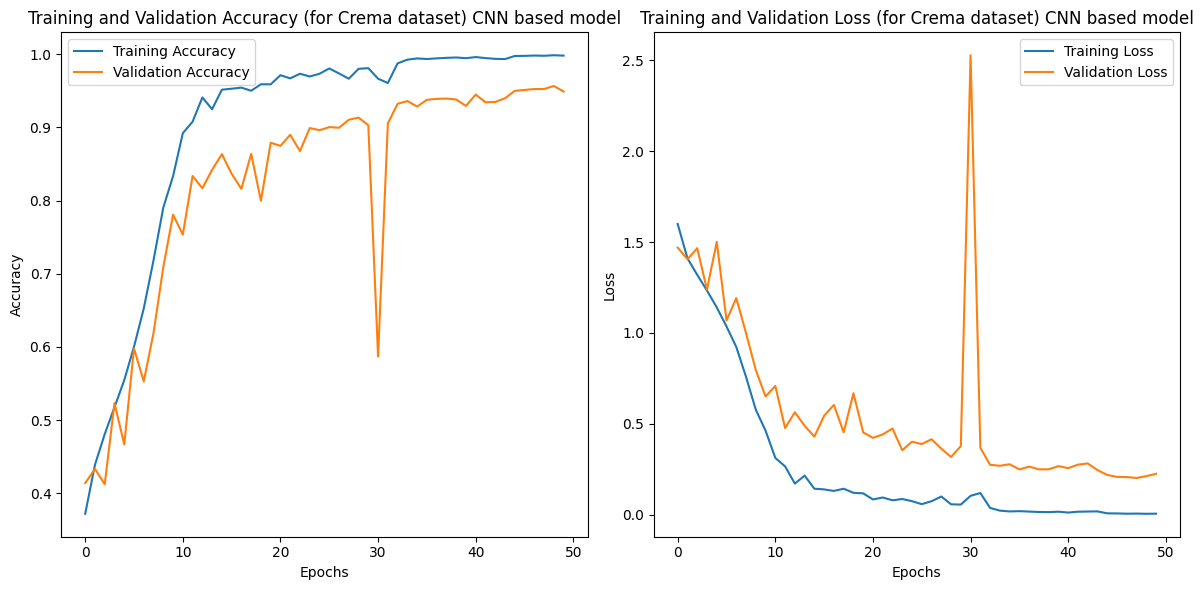

In [42]:
plot_training_history(history_crema,"Crema")

In [43]:
y_pred = model_crema.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

187/187 [==============================] - 9s 46ms/step


array([0, 3, 1, ..., 5, 5, 2])

In [44]:
y_check=np.argmax(y_test,axis=1)
y_check

array([0, 3, 1, ..., 5, 5, 3])

In [45]:
loss,accuracy=model_crema.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 0.23318763077259064
Test Accuracy: 0.9482700824737549


In [46]:
conf=confusion_matrix(y_check,y_pred)
conf

array([[946,  10,  13,   9,   2,   0],
       [ 19, 941,   9,   3,   7,  22],
       [  9,   8, 968,  13,   8,  19],
       [ 24,  16,  11, 994,   9,   6],
       [  4,   8,   9,   6, 814,  16],
       [  1,  16,  22,   3,   6, 983]])

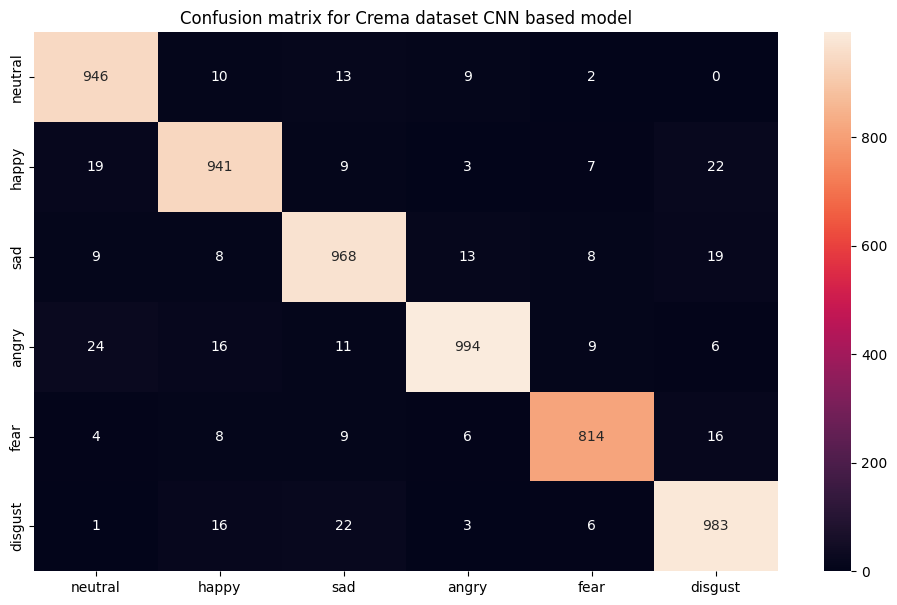

In [47]:
# emotion_names = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
emotion_names = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for Crema dataset {model_type} model')
plt.show()

In [48]:
print(f'Crema dataset {model_type} model Confusion Matrix \n',classification_report(y_check,y_pred,target_names=emotion_names))

Crema dataset CNN based model Confusion Matrix 
               precision    recall  f1-score   support

     neutral       0.94      0.97      0.95       980
       happy       0.94      0.94      0.94      1001
         sad       0.94      0.94      0.94      1025
       angry       0.97      0.94      0.95      1060
        fear       0.96      0.95      0.96       857
     disgust       0.94      0.95      0.95      1031

    accuracy                           0.95      5954
   macro avg       0.95      0.95      0.95      5954
weighted avg       0.95      0.95      0.95      5954



#Ravdess

In [49]:
# Usage
processed_ravdess_path = './ravdess_processed_data.csv'
ravdess_df = load_dataset(processed_ravdess_path)
print("Dataset shape:", ravdess_df.shape)
BATCH_SIZE=64

Dataset shape: (5760, 2377)


In [50]:
ravdess_df = ravdess_df.fillna(0)
print(ravdess_df.isna().any())
ravdess_df.shape
X = ravdess_df.drop(labels='Emotion',axis=1)
Y = ravdess_df['Emotion']

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


In [51]:
label_encoder = LabelEncoder()
Y = to_categorical(label_encoder.fit_transform(Y))
Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [52]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(X, Y, add_dim=True)

In [53]:
model_ravdess = create_model((X_train.shape[1], 1), 7, optimizer, model_loss)
model_ravdess.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 2376, 512)         3072      
                                                                 
 batch_normalization_24 (Ba  (None, 2376, 512)         2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 1188, 512)         0         
 ng1D)                                                           
                                                                 
 conv1d_21 (Conv1D)          (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_25 (Ba  (None, 1188, 512)         2048      
 tchNormalization)                                               
                                                      

In [54]:
model_path = './checkpoints/ravdess_cnn.h5'
history_ravdess=model_ravdess.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE,callbacks=[early_stopping_callback,lr_scheduler, create_model_checkpoint(model_path)])

Epoch 1/50
65/65 [==============================] - ETA: 0s - loss: 1.6690 - accuracy: 0.4478
Epoch 1: val_accuracy improved from -inf to 0.21692, saving model to ./checkpoints/ravdess_cnn.h5
65/65 [==============================] - 24s 343ms/step - loss: 1.6690 - accuracy: 0.4478 - val_loss: 6.0601 - val_accuracy: 0.2169 - lr: 2.5000e-04
Epoch 2/50
65/65 [==============================] - ETA: 0s - loss: 0.9997 - accuracy: 0.6306
Epoch 2: val_accuracy did not improve from 0.21692
65/65 [==============================] - 21s 324ms/step - loss: 0.9997 - accuracy: 0.6306 - val_loss: 6.8913 - val_accuracy: 0.1280 - lr: 2.5000e-04
Epoch 3/50
65/65 [==============================] - ETA: 0s - loss: 0.7117 - accuracy: 0.7574
Epoch 3: val_accuracy did not improve from 0.21692
65/65 [==============================] - 20s 313ms/step - loss: 0.7117 - accuracy: 0.7574 - val_loss: 8.4716 - val_accuracy: 0.1280 - lr: 2.5000e-04
Epoch 4/50
65/65 [==============================] - ETA: 0s - loss: 0.4

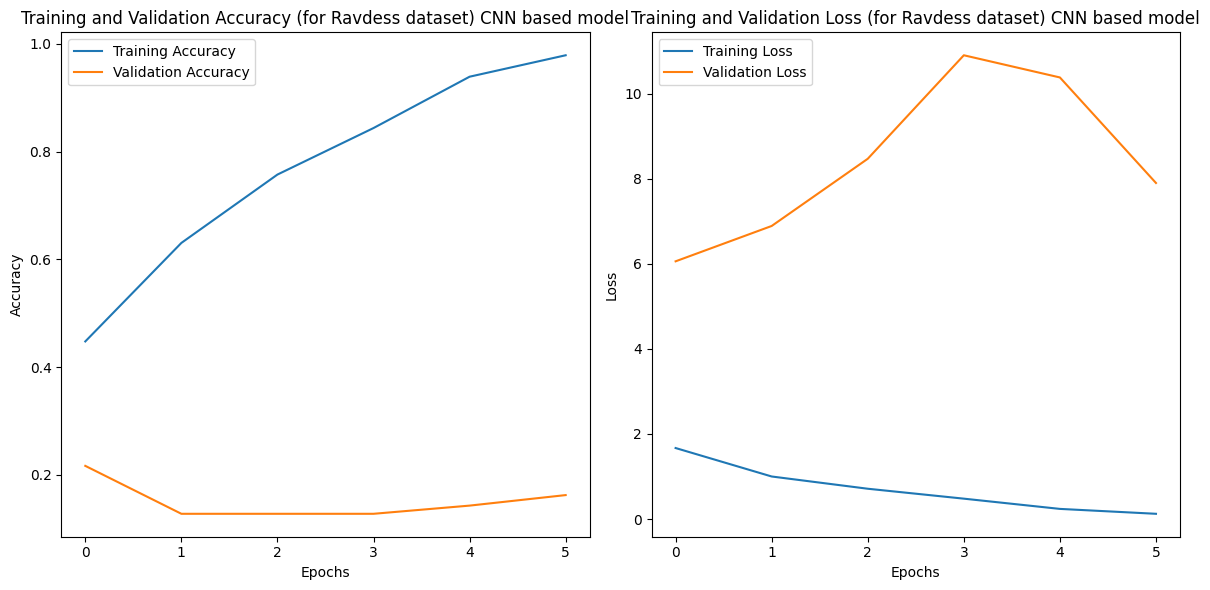

In [55]:
plot_training_history(history_ravdess,"Ravdess")

In [56]:
y_pred = model_ravdess.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

36/36 [==============================] - 2s 45ms/step


array([4, 4, 4, ..., 4, 4, 4])

In [57]:
y_check=np.argmax(y_test,axis=1)
y_check

array([3, 4, 4, ..., 5, 6, 6])

In [58]:
loss,accuracy=model_ravdess.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Test Loss: 5.916146755218506
Test Accuracy: 0.2100694477558136


In [59]:
conf=confusion_matrix(y_check,y_pred)
conf

array([[  0,   0,   0,   0, 139,   0,   0],
       [  0,   0,   0,   0, 162,   0,   0],
       [  0,   0,   0,   2, 136,   0,   0],
       [  0,   0,   0,   0, 157,   0,   0],
       [  0,   0,   1,   1, 241,   0,   3],
       [  0,   0,   0,   0, 163,   0,   0],
       [  0,   0,   0,   6, 140,   0,   1]])

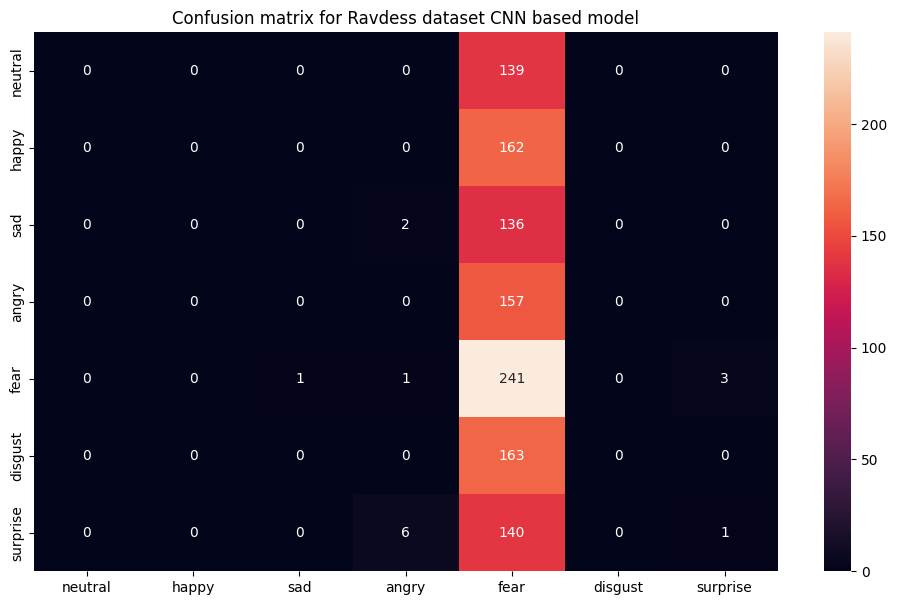

In [60]:
emotion_names = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
# emotion_names = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for Ravdess dataset {model_type} model')
plt.show()

In [61]:
print(f'Ravdess dataset {model_type} model Confusion Matrix \n',classification_report(y_check,y_pred,target_names=emotion_names))

Ravdess dataset CNN based model Confusion Matrix 
               precision    recall  f1-score   support

     neutral       0.00      0.00      0.00       139
       happy       0.00      0.00      0.00       162
         sad       0.00      0.00      0.00       138
       angry       0.00      0.00      0.00       157
        fear       0.21      0.98      0.35       246
     disgust       0.00      0.00      0.00       163
    surprise       0.25      0.01      0.01       147

    accuracy                           0.21      1152
   macro avg       0.07      0.14      0.05      1152
weighted avg       0.08      0.21      0.08      1152



# Crema + Ravdess

In [62]:
# Usage
!ls
processed_combined_path = './ravdess_crema_combined_processed_data.csv'
combined_df = load_dataset(processed_combined_path)
print("Dataset shape:", combined_df.shape)
BATCH_SIZE=64

checkpoints		  ravdess_crema_combined_processed_data.csv
crema_processed_data.csv  ravdess_processed_data.csv
Dataset shape: (35528, 2377)


In [63]:
combined_df = combined_df.fillna(0)
print(combined_df.isna().any())
combined_df.shape
X = combined_df.drop(labels='Emotion',axis=1)
Y = combined_df['Emotion']

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


In [64]:
label_encoder = LabelEncoder()
Y = to_categorical(label_encoder.fit_transform(Y))
Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [65]:
X_train, X_test, X_val, y_train, y_test, y_val = preprocess_data(X, Y, add_dim=True)

In [66]:
model_combined = create_model((X_train.shape[1], 1), 7, optimizer, model_loss)
model_combined.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 2376, 512)         3072      
                                                                 
 batch_normalization_30 (Ba  (None, 2376, 512)         2048      
 tchNormalization)                                               
                                                                 
 max_pooling1d_25 (MaxPooli  (None, 1188, 512)         0         
 ng1D)                                                           
                                                                 
 conv1d_26 (Conv1D)          (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_31 (Ba  (None, 1188, 512)         2048      
 tchNormalization)                                               
                                                      

In [ ]:
model_path = './checkpoints/combined_cnn.h5'
history_combined=model_combined.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE,callbacks=[early_stopping_callback,lr_scheduler, create_model_checkpoint(model_path)])

Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 1.5595 - accuracy: 0.4033
Epoch 1: val_accuracy improved from -inf to 0.29792, saving model to ./checkpoints/combined_cnn.h5
400/400 [==============================] - 136s 336ms/step - loss: 1.5595 - accuracy: 0.4033 - val_loss: 1.7441 - val_accuracy: 0.2979 - lr: 1.2500e-04
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 1.2810 - accuracy: 0.5010
Epoch 2: val_accuracy improved from 0.29792 to 0.44671, saving model to ./checkpoints/combined_cnn.h5
400/400 [==============================] - 133s 332ms/step - loss: 1.2810 - accuracy: 0.5010 - val_loss: 1.3535 - val_accuracy: 0.4467 - lr: 1.2500e-04
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 1.1488 - accuracy: 0.5585
Epoch 3: val_accuracy improved from 0.44671 to 0.53148, saving model to ./checkpoints/combined_cnn.h5
400/400 [==============================] - 134s 335ms/step - loss: 1.1488 - accuracy: 0.5585 - val_loss: 

In [ ]:
plot_training_history(history_combined,"Ravdess + Crema")

In [ ]:
y_pred = model_combined.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
y_check=np.argmax(y_test,axis=1)
y_check

In [ ]:
loss,accuracy=model_combined.evaluate(X_test,y_test,verbose=0)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

In [ ]:
conf=confusion_matrix(y_check,y_pred)
conf

In [ ]:
emotion_names = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
# emotion_names = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust']
conf=confusion_matrix(y_check,y_pred)
cm=pd.DataFrame(
    conf,index=[i for i in emotion_names],
    columns=[i for i in emotion_names]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'Confusion matrix for Ravdess + Crema dataset {model_type} model')
plt.show()

In [ ]:
print(f'Ravdess + Crema dataset {model_type} model Confusion Matrix \n',classification_report(y_check,y_pred,target_names=emotion_names))